# Text Classification using Word Embedding in Keras

In this notebook, I'll demonstrate how to use the Embedding layer in keras for doing text classification. The task at hand is to build a classifier to distinguish good reviews from bad ones in amazon reviews of miscellaneous products.

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [54]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, Flatten, Dropout, Embedding
from keras.models import Sequential

from keras.optimizers import SGD

In [109]:
learning_rate = 0.05
num_epochs = 200

In [14]:
data = pd.read_table('amazon_cells_labelled.txt', header = None)
data.columns = ['Text', 'Reviews']
pd.set_option('display.max_colwidth', -1)
print(f"Size of the data is: {data.shape}")
data.head()

Size of the data is: (1000, 2)


,Text,Reviews
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


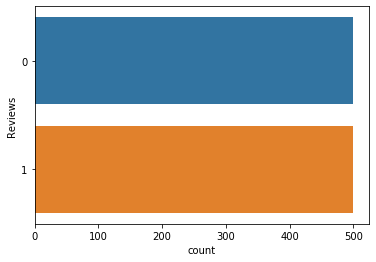

In [21]:
sns.countplot(y = "Reviews", data = data)
plt.show()

In [24]:
X = data.Text; y = data.Reviews
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.05, random_state = 0)

# Data Preparation

## Tokenization
We need to tokenize the text into integer indices and express the sentences or reviews as a set of integers.

**Tokenization**:

Keras' `Tokenizer()` helps achieve this task.

Tokenizer's built in `fit_on_texts` method will take in the documents as input and assign an index to each and every unique word in the document.

We could check this using the `word_index` attribute in the Tokenizer.

## Encoding

We need to encode the sentences using these indices obtained as a result of the tokenization above. The `Tokenizer` object created in the previous step has a method `text_to_sequences` which helps us do this task easily.

## Uniform Length Padding

Keras prefers it's input documents to be all of the same length. Hence we'll have to find out the length of the longest review and make every other review of the same length by using `pad_sequences` method in keras which will basically append 0s post the shorter reviews to make their length equal that of the review with maximum tokens. 

In [32]:
# Tokenization
Tk = Tokenizer()
Tk.fit_on_texts(X_train)

# Watch how big is the vocabulary
print(f"There are {len(Tk.word_index)} unique words in our vocabulary.")

There are 1838 unique words in our vocabulary.


In [42]:
# Define the vocabulary size accordingly
vocab_size = len(Tk.word_index) + 1
print(f"Our text vocabulary is of size {vocab_size}.")

Our text vocabulary is of size 1839.


In [33]:
# Encode all the sentences in our data to convert them into integer index representations.
encoded_train = Tk.texts_to_sequences(X_train)
encoded_test = Tk.texts_to_sequences(X_test)

In [38]:
# The integer index coded representation for each review is as follows
[print(i) for i in encoded_train[:5]]

[181, 9]
[2, 257, 36, 7, 54, 114, 1, 534, 5, 781]
[535, 93, 2, 324]
[2, 83, 100, 55, 107, 14, 7, 24]
[1, 122, 398, 1, 9, 325, 17, 3, 123, 56, 108, 1, 168, 326, 226, 3, 1, 115, 11, 37, 4, 782, 536, 783]


[None, None, None, None, None]

In [44]:
# Let's find out the length of the biggest review for padding purposes
max_length_train = max([len(i) for i in encoded_train])
max_length_test = max([len(i) for i in encoded_test])

max_length = max(max_length_train, max_length_test)

print(f"The biggest review has {max_length} number of words present in it.")

The biggest review has 30 number of words present in it.


In [47]:
# Pad the documents to the maximum length for keras to accept input while building a model
padded_train = pad_sequences(encoded_train, maxlen = max_length, padding = 'post')
padded_test = pad_sequences(encoded_test, maxlen = max_length, padding = 'post')

# Top 5 results in padded train sequence. 
# We can see that each and every review has been padded with 0s at it's 
# end to bring the lengths of all the datapoints on the same baseline
[print(i) for i in padded_train[:5]]

[181   9   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[  2 257  36   7  54 114   1 534   5 781   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[535  93   2 324   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[  2  83 100  55 107  14   7  24   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[  1 122 398   1   9 325  17   3 123  56 108   1 168 326 226   3   1 115
  11  37   4 782 536 783   0   0   0   0   0   0]


[None, None, None, None, None]

# Model Architecture

Our training data has a vocabulary size of 1839.

Each input has 30 words or 30 tokens associated with it.

Let us choose an embedding dimension of 50 in order to keep things simple.

Every word will return a 50 dimensional vector as it's embedded output.

There are 30 such words per datapoint which means we'll be getting 30 * 50 = 1500 output activations which need to be flattened to bring them into one single layer which can be fed to the next FC layer for doing binary classification.

Let's construct this model using the `Sequential` API in keras

**NOTE: Embedding layer parameters**:

- input_dim - It is the size of our vocabulary (1839 in our case).
- input_length - Length of input sequences (30 in our case).
- output_dimension - Dimension of the dense embedding (50 which we have arbit selected).

[Refer this link](https://keras.io/layers/embeddings/) for details about several other parameters which we won't be using here.

In [110]:
d = 50 # It is the neurons in the embedding layer.
model = Sequential([
    Embedding(input_dim = vocab_size, input_length = max_length, output_dim = d),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

In [111]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 50)            91950     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1500)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1501      
Total params: 93,451
Trainable params: 93,451
Non-trainable params: 0
_________________________________________________________________


We see that the `Embedding` layer has to learn 50 * 1839 = 91950 weights to uniquely represent each word as a vector of dimension 50. 

Since each sentence/review is only 30 words long and each word is described by 50 neuron activations, we get the training parameters of the NN architecture in the first layer to be 30 * 50 = 1500 which are flattened with `Flatten` layer.

Eventually we have a `Dense` layer which does the job of classifying the reviews into 1s(positive) or 0s(negative)

Let's now compile the model and use sgd with learning rate 0.01 to optimize the loss.

In [112]:
model.compile(optimizer = SGD(lr = learning_rate), loss =  'binary_crossentropy', 
              metrics = ['accuracy'])

# Fit & Evaluate the Model

In [113]:
model.fit(padded_train, y_train, epochs = num_epochs, verbose = 1, 
          validation_split = 0.2, batch_size = 32)

Train on 760 samples, validate on 190 samples
Epoch 1/200
760/760 [==============================] - 0s 346us/step - loss: 0.6924 - accuracy: 0.5276 - val_loss: 0.6945 - val_accuracy: 0.4737
Epoch 2/200
760/760 [==============================] - 0s 92us/step - loss: 0.6918 - accuracy: 0.5395 - val_loss: 0.6961 - val_accuracy: 0.4737
Epoch 3/200
760/760 [==============================] - 0s 97us/step - loss: 0.6910 - accuracy: 0.5303 - val_loss: 0.6950 - val_accuracy: 0.4789
Epoch 4/200
760/760 [==============================] - 0s 101us/step - loss: 0.6900 - accuracy: 0.5553 - val_loss: 0.6951 - val_accuracy: 0.4737
Epoch 5/200
760/760 [==============================] - 0s 138us/step - loss: 0.6894 - accuracy: 0.5316 - val_loss: 0.6938 - val_accuracy: 0.4895
Epoch 6/200
760/760 [==============================] - 0s 93us/step - loss: 0.6884 - accuracy: 0.5408 - val_loss: 0.6919 - val_accuracy: 0.5421
Epoch 7/200
760/760 [==============================] - 0s 124us/step - loss: 0.6876 - a

Epoch 57/200
760/760 [==============================] - 0s 89us/step - loss: 0.5715 - accuracy: 0.8132 - val_loss: 0.6354 - val_accuracy: 0.6211
Epoch 58/200
760/760 [==============================] - 0s 93us/step - loss: 0.5668 - accuracy: 0.8211 - val_loss: 0.6291 - val_accuracy: 0.6316
Epoch 59/200
760/760 [==============================] - 0s 76us/step - loss: 0.5613 - accuracy: 0.8197 - val_loss: 0.6308 - val_accuracy: 0.6053
Epoch 60/200
760/760 [==============================] - 0s 76us/step - loss: 0.5564 - accuracy: 0.8158 - val_loss: 0.6217 - val_accuracy: 0.6632
Epoch 61/200
760/760 [==============================] - 0s 72us/step - loss: 0.5508 - accuracy: 0.8237 - val_loss: 0.6213 - val_accuracy: 0.6474
Epoch 62/200
760/760 [==============================] - 0s 75us/step - loss: 0.5458 - accuracy: 0.8316 - val_loss: 0.6168 - val_accuracy: 0.6632
Epoch 63/200
760/760 [==============================] - 0s 68us/step - loss: 0.5401 - accuracy: 0.8316 - val_loss: 0.6124 - val_ac

760/760 [==============================] - 0s 114us/step - loss: 0.2900 - accuracy: 0.9474 - val_loss: 0.5061 - val_accuracy: 0.7421
Epoch 114/200
760/760 [==============================] - 0s 100us/step - loss: 0.2872 - accuracy: 0.9500 - val_loss: 0.5074 - val_accuracy: 0.7316
Epoch 115/200
760/760 [==============================] - 0s 88us/step - loss: 0.2830 - accuracy: 0.9500 - val_loss: 0.5069 - val_accuracy: 0.7316
Epoch 116/200
760/760 [==============================] - 0s 74us/step - loss: 0.2797 - accuracy: 0.9539 - val_loss: 0.5060 - val_accuracy: 0.7316
Epoch 117/200
760/760 [==============================] - 0s 71us/step - loss: 0.2749 - accuracy: 0.9579 - val_loss: 0.5031 - val_accuracy: 0.7474
Epoch 118/200
760/760 [==============================] - 0s 67us/step - loss: 0.2714 - accuracy: 0.9592 - val_loss: 0.5037 - val_accuracy: 0.7316
Epoch 119/200
760/760 [==============================] - 0s 76us/step - loss: 0.2684 - accuracy: 0.9539 - val_loss: 0.5040 - val_accurac

760/760 [==============================] - 0s 103us/step - loss: 0.1390 - accuracy: 0.9934 - val_loss: 0.5031 - val_accuracy: 0.7632
Epoch 170/200
760/760 [==============================] - 0s 95us/step - loss: 0.1364 - accuracy: 0.9947 - val_loss: 0.5016 - val_accuracy: 0.7579
Epoch 171/200
760/760 [==============================] - 0s 72us/step - loss: 0.1349 - accuracy: 0.9947 - val_loss: 0.5020 - val_accuracy: 0.7526
Epoch 172/200
760/760 [==============================] - 0s 93us/step - loss: 0.1323 - accuracy: 0.9934 - val_loss: 0.5069 - val_accuracy: 0.7579
Epoch 173/200
760/760 [==============================] - 0s 75us/step - loss: 0.1313 - accuracy: 0.9947 - val_loss: 0.5039 - val_accuracy: 0.7579
Epoch 174/200
760/760 [==============================] - 0s 93us/step - loss: 0.1298 - accuracy: 0.9947 - val_loss: 0.5066 - val_accuracy: 0.7632
Epoch 175/200
760/760 [==============================] - 0s 107us/step - loss: 0.1277 - accuracy: 0.9947 - val_loss: 0.5079 - val_accurac

Let's predict on both train and test data to evaluate the performance of our model. 

In [121]:
def evaluate_performance(y_true, y_pred, title, labels):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"Accuracy:  {np.round((tp + tn) / (tp + fp + tn + fn), 3)}")
    print(f"Recall:    {np.round(tp / (tp + fn), 3)}")
    print(f"Precision: {np.round(tp / (tp + fp), 3)}")
    print(f"f1 score:  {np.round(2 * tp / (2 * tp + fp + fn), 3)}\n")
    
    data = confusion_matrix(y_true, y_pred)
    data = pd.DataFrame(data/np.sum(data), index = labels, columns = labels)
    print(data)
    akws = {"ha": 'center',"va": 'center', 'size':15}
    sns.heatmap(data, annot = True, annot_kws=akws)
#     plt.axis('Off')
    plt.suptitle(title)
    plt.xticks(rotation = 90); plt.yticks(rotation = 0)
    plt.show()

**Evaluate on Train** 

Accuracy:  0.951
Recall:    0.943
Precision: 0.957
f1 score:  0.95

          Negative  Positive
Negative  0.478947  0.021053
Positive  0.028421  0.471579


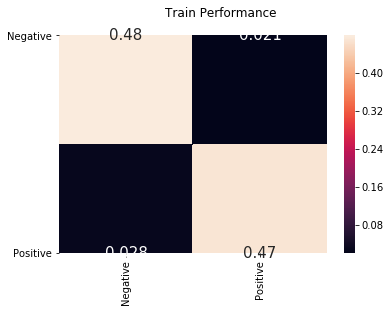

In [122]:
y_pred_train = model.predict_classes(padded_train)
evaluate_performance(y_train, y_pred_train, title = 'Train Performance',
                     labels = ['Negative', 'Positive'])

**Evaluate on Test** 

Accuracy:  0.86
Recall:    0.88
Precision: 0.846
f1 score:  0.863

          Negative  Positive
Negative  0.42      0.08    
Positive  0.06      0.44    


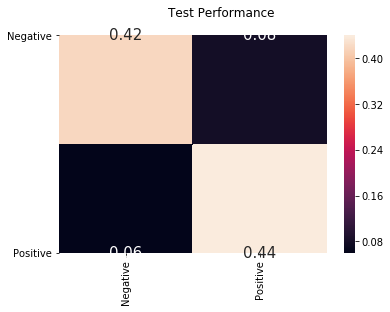

In [123]:
y_pred_test = model.predict_classes(padded_test)
evaluate_performance(y_test, y_pred_test, title = 'Test Performance',
                     labels = ['Negative', 'Positive'])